# Experimental setting

In [62]:
import pandas as pd
import numpy as np
import random

import os, time, tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

In [46]:
def loadData(file_name):
    table = pd.read_csv(file_name)
    table = table[(table.group != 'Other')&(table.start < 1995)&(table.end > 2000)]
    table['image'] = table.group+'-'+table.endpoint+'.png'
    table = table.sort_values('image')
    return table

def getSamples(df,sample_size=200):
    endpoint_size = len(df)
    group_series = df.group.value_counts()
    img_list = []
    for i in group_series.keys():
        sample_size_sub = int(sample_size*group_series[i]/endpoint_size)
        img_list += random.sample(df[df.group == i].image.tolist(),sample_size_sub)
    while len(set(img_list)) < sample_size:
        img_list += random.sample(df.image.tolist(),sample_size - len(set(img_list)))
    img_list = list(set(img_list))
    return df[df.image.isin(img_list)].image.tolist()

def getPlots(start_num, end_num, img_name_list, n_col=5, img_dir='plots'):
    input_list = img_name_list[start_num:end_num]
    n_row = np.ceil((end_num - start_num)/n_col)
    plt.figure(figsize =(20,20/n_col*n_row))

    for i in tqdm.tqdm(range(len(input_list))):
        if i >= n_row*n_col:
            print('Out of range!')
            break
        image = Image.open(os.path.join(img_dir, input_list[i]))
        plt.subplot(n_row,n_col,i+1) # how to hide gridlines in subplots
        plt.imshow(image,interpolation='none')

def drawTestPlot(ones, zeros, groups):
    # set width of bar 
    barWidth = 0.25
    fig = plt.subplots(figsize =(len(groups), 4))

    # Set position of bar on X axis 
    br1 = np.arange(len(groups)) 
    br2 = [x + barWidth for x in br1] 

    plt.bar(br1, ones, color ='g', width = barWidth, edgecolor ='white', label ='Labeled as 1') 
    plt.bar(br2, zeros, color ='r', width = barWidth, edgecolor ='white', label ='Labeled as 0')  
    plt.xlabel('disease groups', fontweight ='bold') 
    plt.ylabel('percentage', fontweight ='bold') 
    plt.xticks([r + barWidth for r in range(len(ones))], groups, rotation='vertical',fontsize=13)
    plt.yticks(np.linspace(0,1.2,7),fontsize=13)
    plt.legend(loc='upper right')
    plt.grid(b=None)
    plt.show()

In [7]:
table_poi = loadData('results_short_window_poisson1.csv')
len(table_poi)

1666

## Annotation

In [78]:
img_list = getSamples(table_poi)
len(img_list)

200

100%|██████████| 60/60 [00:02<00:00, 22.89it/s]


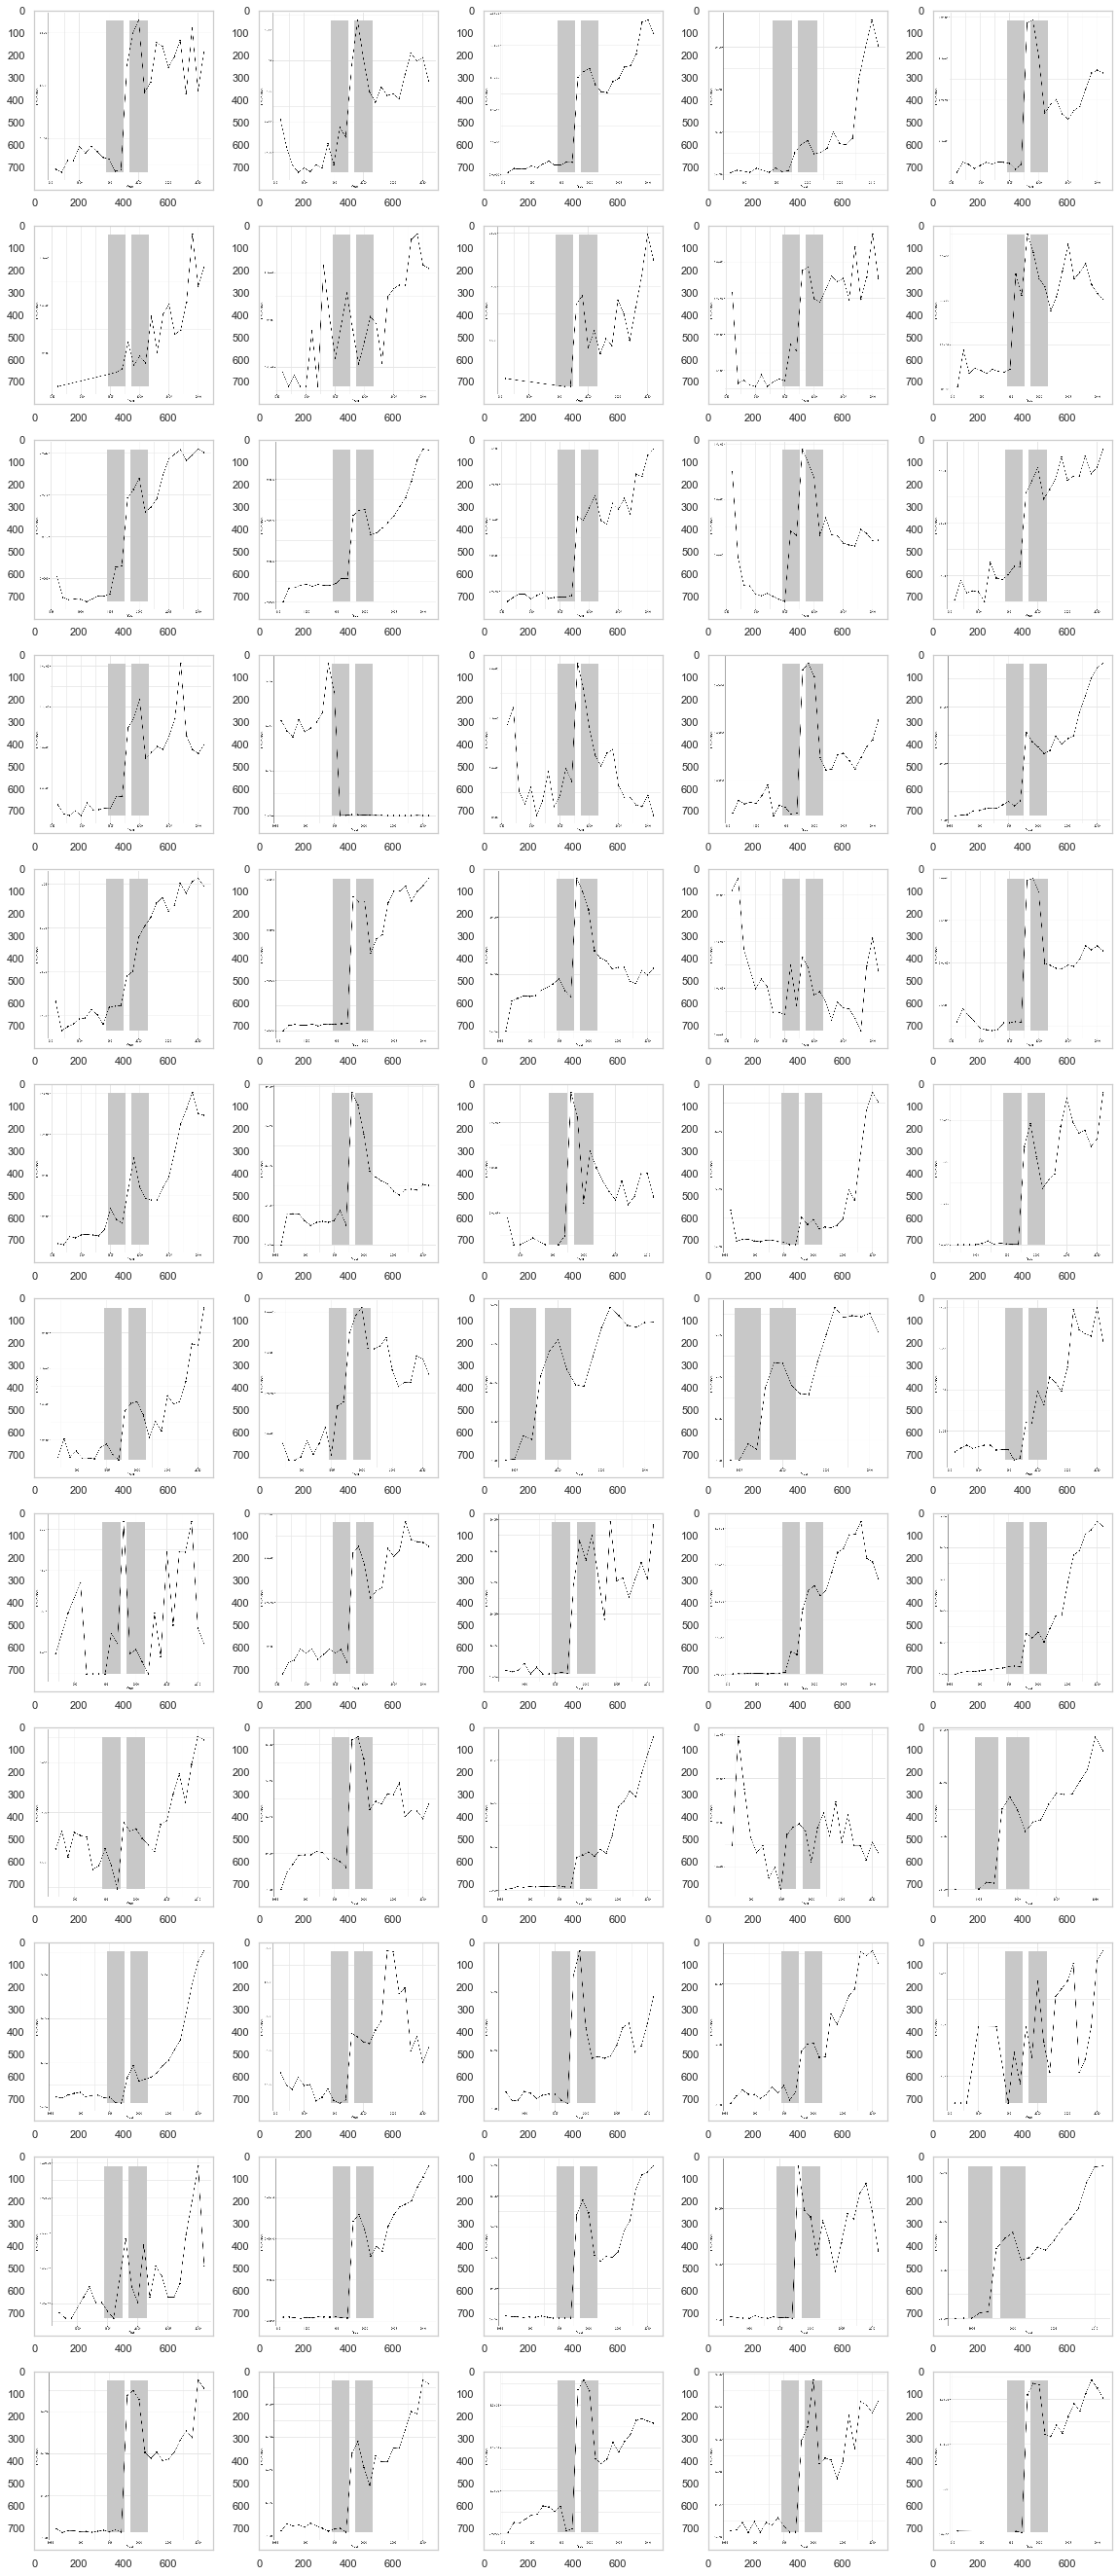

In [527]:
getPlots(0, 60, img_name_list=img_list)

In [95]:
outcome = [
    1,1,1,1,1, 1,0,1,1,-1, 1,1,1,-1,1, 1,0,-1,1,1, 1,1,-1,-1,1, 1,1,1,1,1, 1,1,1,1,1, -1,1,1,1,1,
    1,1,1,-1,1, 1,1,1,1,-1, -1,1,1,1,1, 1,1,1,1,1, 1,1,1,1,1, 1,-1,1,1,1, 1,1,1,1,1, 1,1,1,1,0,
    1,-1,1,1,-1, 1,-1,-1,-1,1, 1,1,1,1,1, 1,1,1,1,1, 1,-1,1,-1,1, -1,1,1,-1,1, 1,0,1,1,-1, 1,-1,1,1,1,
    1,1,-1,1,0, 0,0,0,1,0, 0,0,-1,0,-1, 0,-1,0,1,1, 1,-1,1,-1,1, 1,1,1,1,1, 1,1,-1,1,1, 1,1,-1,1,0,
    1,1,0,1,1, 1,1,1,-1,-1, 1,1,1,0,-1, 1,1,-1,-1,1, 1,-1,-1,1,1, 1,1,1,1,1, 1,1,1,1,-1, 1,1,1,1,1
]
len(outcome)

200

In [8]:
df = pd.read_csv('annotation.csv')
img_list, outcome = df.image.tolist(), df.outcome.tolist()

In [9]:
print('Total annotation',str(len(outcome)))
print('Number of y',str(sum(1 for i in outcome if i != -1)))
print('Number of 1s',str(sum(1 for i in outcome if i == 1)))
print('Number of 0s',str(sum(1 for i in outcome if i == 0)))

Total annotation 200
Number of y 163
Number of 1s 146
Number of 0s 17


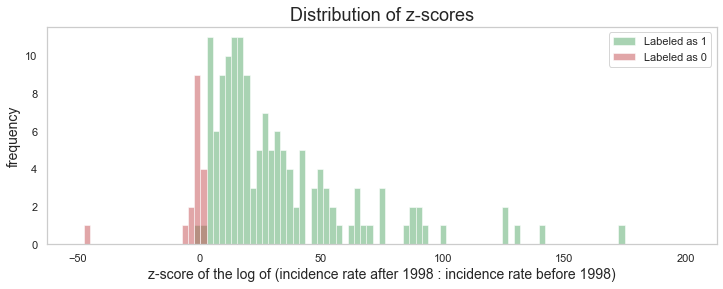

In [28]:
plt.figure(figsize=(12, 4))
data = pd.DataFrame([outcome,round(table_poi[table_poi.image.isin(img_list)].zscore,2).tolist()]).T.dropna()
data = data.to_numpy()
a = data[data[:,0] == 1]
a = a[:,1].reshape(-1,1)
b = data[data[:,0] == 0]
b = b[:,1].reshape(-1,1)

bins = np.linspace(-50, 200, 100)
plt.hist(a, bins, alpha=0.5, label='Labeled as 1', color='g')
plt.hist(b, bins, alpha=0.5, label='Labeled as 0', color='r')
plt.legend(loc='upper right')
plt.xlabel('z-score of the log of (incidence rate after 1998 : incidence rate before 1998)',size=14)
plt.ylabel('frequency',size=14)
plt.title('Distribution of z-scores',size=18)
plt.grid(b=None)
plt.show()

## Training

accuracy:  0.9938650306748467
coef:  [[0.81632657]]   intercept:  [-1.48163262]
confusion matrix:
[[ 17   0]
 [  1 145]]
R-squared:  0.9343271555197421


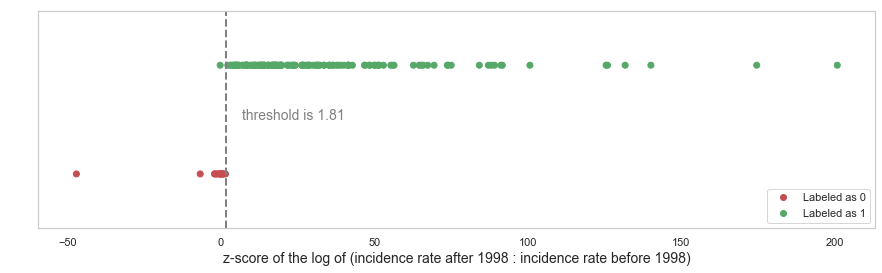

In [57]:
data = np.array([outcome,round(table_poi[table_poi.image.isin(img_list)].zscore,2).tolist()]).T
data_selected = data[data[:,0] != -1]
y = data_selected[:,0]
x = data_selected[:,1].reshape(-1,1)

lr = SVC(kernel='linear',probability=True).fit(x, y)
# lr = LogisticRegression().fit(x, y)
print('accuracy: ',str(lr.score(x,y)))
print('coef: ',str(lr.coef_),'  intercept: ',str(lr.intercept_))
print('confusion matrix:')
print(metrics.confusion_matrix(y, lr.predict(x)))
print('R-squared: ',str(metrics.r2_score(y, lr.predict(x))))

plt.figure(figsize=(15, 4))
scatter = plt.scatter(x.T[0], y,c=y, cmap=ListedColormap(['r','g']))
plt.legend(handles=scatter.legend_elements()[0], labels=['Labeled as 0', 'Labeled as 1'], loc='lower right')
plt.axvline(-lr.intercept_/lr.coef_[0], color='grey', linestyle='dashed', linewidth=2)
plt.yticks([-.5,1.5],color='white')
plt.xlabel('z-score of the log of (incidence rate after 1998 : incidence rate before 1998)',size=14)
plt.text(-lr.intercept_/lr.coef_[0]+5, .5, 'threshold is '+'{0:.2f}'.format((-lr.intercept_/lr.coef_[0])[0]),size=14,color='grey')
plt.grid(b=None)
plt.show()

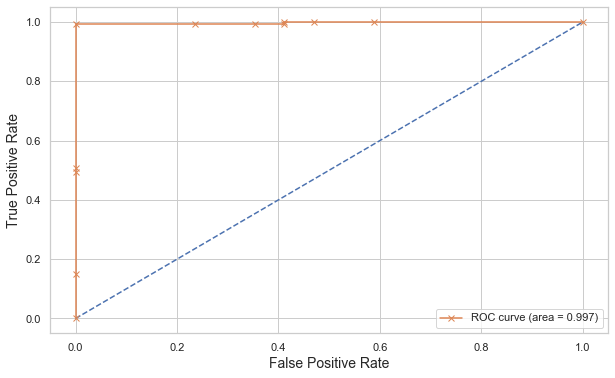

In [58]:
ns_probs, lr_probs = [0 for _ in range(len(y))], lr.predict_proba(x)[:, 1]
ns_auc, lr_auc = metrics.roc_auc_score(y, ns_probs), metrics.roc_auc_score(y, lr_probs)
ns_fpr, ns_tpr, _ = metrics.roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y, lr_probs)

plt.figure(figsize=(10, 6))
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='x', label='ROC curve (area = %0.3f)' % lr_auc)
plt.xlabel('False Positive Rate',size=14)
plt.ylabel('True Positive Rate',size=14)
plt.legend()
plt.show()

## Validation

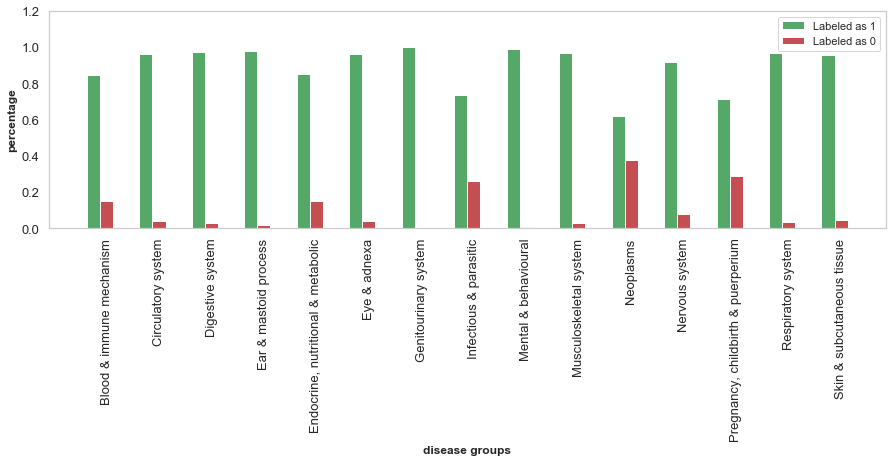

In [59]:
ones, zeros, groups = [], [], table_poi.group.unique().tolist()[:-1]
for i in groups:
    x_test = table_poi[table_poi.group == i][['zscore']].to_numpy()
    y_hat = lr.predict(x_test)
    zeros.append(np.count_nonzero(y_hat == 0)/len(y_hat))
    ones.append(np.count_nonzero(y_hat != 0)/len(y_hat))
drawTestPlot(ones, zeros, groups)

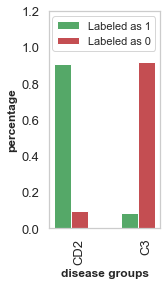

In [60]:
a = table_poi[table_poi.group == 'Neoplasms']
a['header'] = a.endpoint.str[:2]
a['Neoplasm Subgroups'] = ['C3' if i == 'C3' else 'CD2' if i == 'CD' else 'Other' for i in a.header]

ones, zeros, groups = [], [], ['CD2','C3']
for i in groups:
    x_test = a[a['Neoplasm Subgroups'] == i][['zscore']].to_numpy()
    y_hat = lr.predict(x_test)
    zeros.append(np.count_nonzero(y_hat == 0)/len(y_hat))
    ones.append(np.count_nonzero(y_hat != 0)/len(y_hat))
drawTestPlot(ones, zeros, groups)

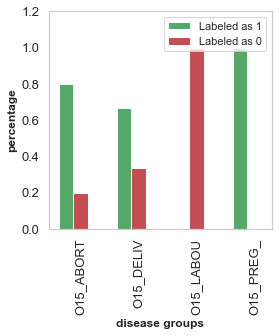

In [61]:
a = table_poi[table_poi.group == 'Pregnancy, childbirth & puerperium']
a['Subgroups'] = a.endpoint.str[:9]

ones, zeros, groups = [], [], ['O15_ABORT','O15_DELIV','O15_LABOU','O15_PREG_']
for i in groups:
    x_test = a[a['Subgroups'] == i][['zscore']].to_numpy()
    y_hat = lr.predict(x_test)
    zeros.append(np.count_nonzero(y_hat == 0)/len(y_hat))
    ones.append(np.count_nonzero(y_hat != 0)/len(y_hat))
drawTestPlot(ones, zeros, groups)

In [691]:
img0s = getSamples(table_poi[table_poi.y_hat == 0],sample_size=100)
img1s = getSamples(table_poi[table_poi.y_hat == 1],sample_size=100)

100%|██████████| 50/50 [00:01<00:00, 28.08it/s]


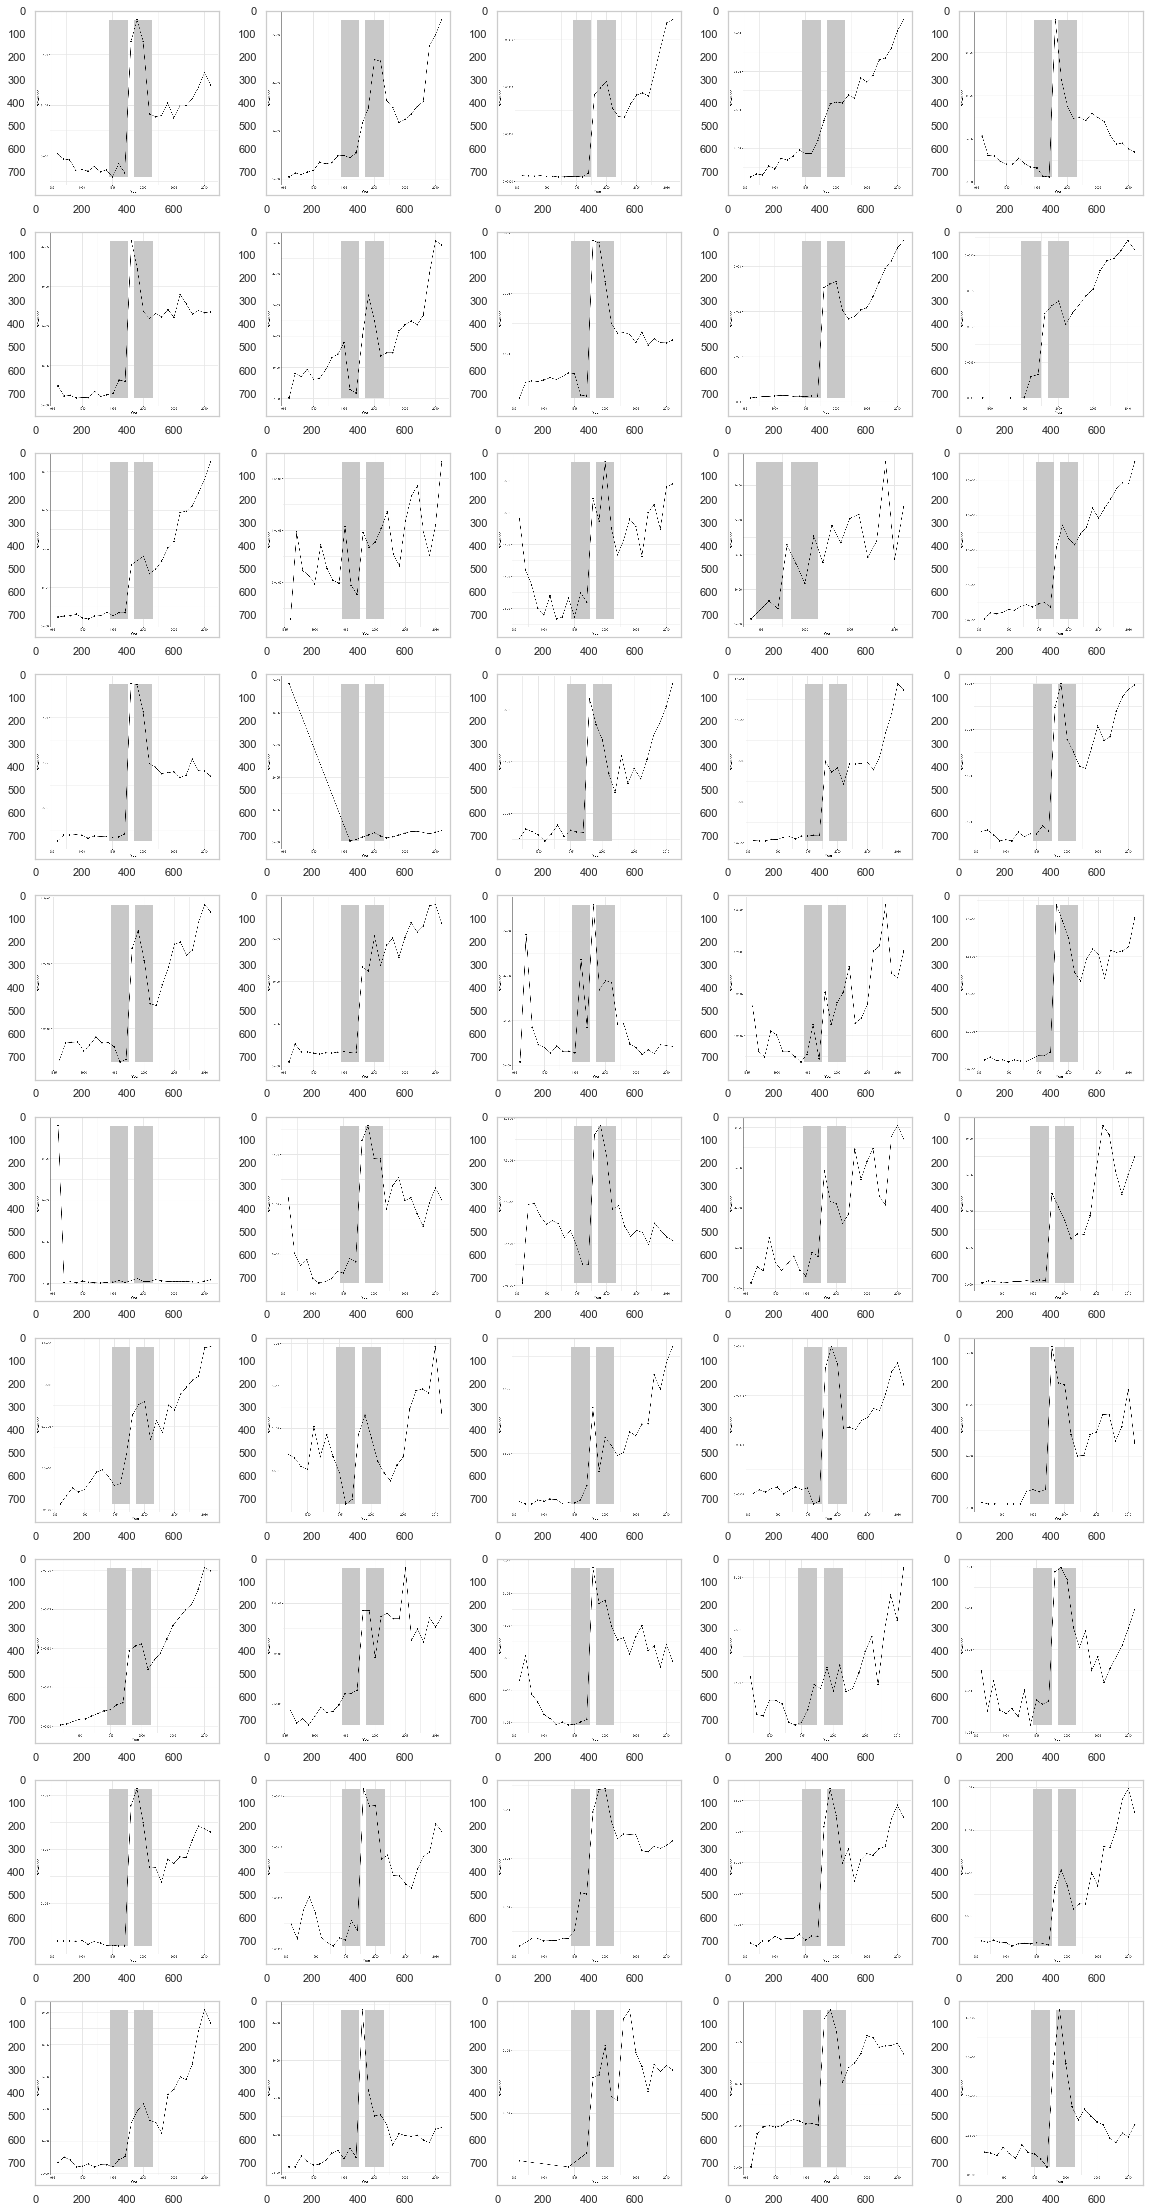

In [746]:
getPlots(50, 100, img_name_list=img1s)

In [747]:
outcome0s = [
    0,0,-1,-1,0, 0,0,0,0,0, 0,0,0,-1,0, 0,0,-1,0,0, -1,0,0,0,0, -1,0,0,0,0, -1,-1,-1,-1,-1, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,
    0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,-1,0,0,0, 0,0,0,0,-1, 0,0,0,0,0, 0,0,0,-1,0, -1,0,-1,-1,0, 0,0,0,0,0, 0,0,0,0,0
]
outcome1s = [
    1,1,1,1,-1, 1,1,1,1,1, 1,-1,1,1,1, -1,1,1,1,1, 1,1,1,-1,1, 1,1,1,1,1, 1,1,1,1,1, 1,1,1,1,1, 1,1,1,1,-1, 1,1,-1,1,1,
    1,1,1,1,1, 1,-1,1,1,1, 1,0,1,-1,1, 1,-1,1,1,1, 1,1,-1,-1,1, -1,1,1,1,1, 1,-1,1,1,1, 1,1,1,0,1, 1,1,1,1,1, 1,1,1,1,1 
]

In [49]:
test = pd.DataFrame({'image':img0s+img1s,'outcome':outcome0s+outcome1s,'predict':[0]*100+[1]*100})
test = test.merge(table_poi[['image','zscore','endpoint','group']], on='image', how='left')

test_ = test[test.outcome != -1]
x_test, y_test = test_.zscore.to_numpy().reshape(-1,1), test_.outcome.tolist()
test_.head(3)

,image,outcome,predict,zscore,endpoint,group
0,Blood & immune mechanism-D3_ACQCOAFACDEF.png,0,0,0.272595,D3_ACQCOAFACDEF,Blood & immune mechanism
1,Blood & immune mechanism-D3_IMMUDEFNAS.png,0,0,-1.976597,D3_IMMUDEFNAS,Blood & immune mechanism
4,Blood & immune mechanism-D3_POLYCLOHYPERGAMMA.png,0,0,-1.386800,D3_POLYCLOHYPERGAMMA,Blood & immune mechanism


In [50]:
test = pd.read_csv('annotation_test.csv')

accuracy:  0.9941176470588236
confusion matrix:
[[84  1]
 [ 0 85]]
R-squared:  0.9764705882352941


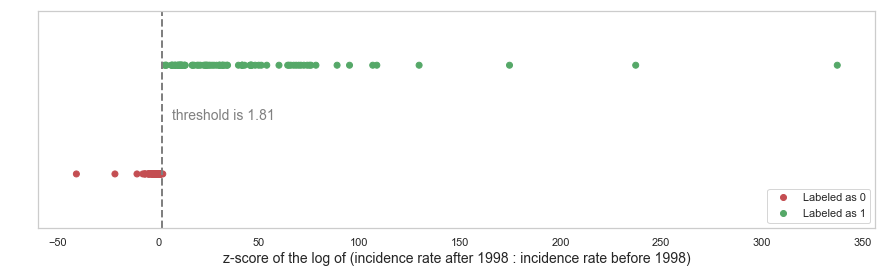

In [68]:
print('accuracy: ',str(lr.score(x_test,y_test)))
print('confusion matrix:')
print(metrics.confusion_matrix(y_test, lr.predict(x_test)))
print('R-squared: ',str(metrics.r2_score(y_test, lr.predict(x_test))))

plt.figure(figsize=(15, 4))
scatter = plt.scatter(x_test.T[0], y_test,c=y_test, cmap=ListedColormap(['r','g']))
plt.legend(handles=scatter.legend_elements()[0], labels=['Labeled as 0', 'Labeled as 1'], loc='lower right')
plt.axvline(-lr.intercept_/lr.coef_[0], color='grey', linestyle='dashed', linewidth=2)
plt.grid(b=None)
plt.yticks([-.5,1.5],color='white')
plt.xlabel('z-score of the log of (incidence rate after 1998 : incidence rate before 1998)',size=14)
plt.text(-lr.intercept_/lr.coef_[0]+5, .5, 'threshold is '+'{0:.2f}'.format((-lr.intercept_/lr.coef_[0])[0]),size=14,color='grey')
plt.show()

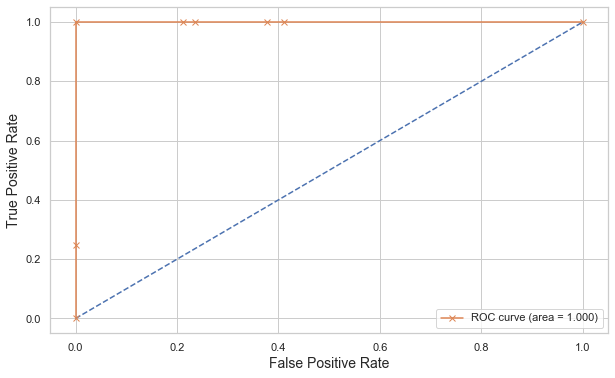

In [69]:
ns_probs, lr_probs = [0 for _ in range(len(y_test))], lr.predict_proba(x_test)[:, 1]
ns_auc, lr_auc = metrics.roc_auc_score(y_test, ns_probs), metrics.roc_auc_score(y_test, lr_probs)
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)

plt.figure(figsize=(10, 6))
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='x', label='ROC curve (area = %0.3f)' % lr_auc)
plt.xlabel('False Positive Rate',size=14)
plt.ylabel('True Positive Rate',size=14)
plt.legend()
plt.show()